This anlysis is taken from:  
http://www.real-statistics.com/regression/hypothesis-testing-significance-regression-line-slope/comparing-slopes-two-independent-samples/

### Motivation
This notebook is being created to get some practice with comparing the significance in the difference between the slopes of two regression lines.  The reference above was done in Excel.

### Problem Statement and Definitions
Start with two sets of data: logevity vs. number of cigarettes per day for two populations, one for men and one for women.  

The test statistic is:  
\begin{align*}
t = \frac{w_{1, men} - w_{1, women}}{\sqrt{s_{w_{1, men}}^2 + s_{w_{1, women}}^2}}
\end{align*}

Let's start with a quick plot.

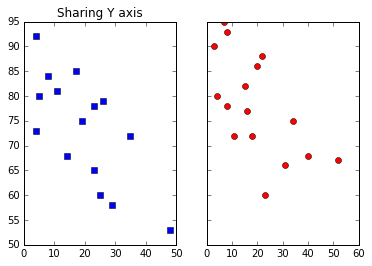

In [18]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
%matplotlib inline
men_data = pd.read_csv('https://raw.githubusercontent.com/MichaelSzczepaniak/SlopeInference/master/men_cig_life_exp.csv')
women_data = pd.read_csv('https://raw.githubusercontent.com/MichaelSzczepaniak/SlopeInference/master/women_cig_life_exp.csv')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(men_data['cig_x'], men_data['life_exp'], 'bs')
ax1.set_title('Sharing Y axis')
ax2.plot(women_data['cig_x'], women_data['life_exp'], 'ro')

In [2]:
import pandas as pd, numpy as np
women_data.head(5)

,cig_x,life_exp
0,22,88
1,7,95
2,20,86
3,23,60
4,15,82


In [3]:
def trainLinear(X, T, as_matrix=True):
    """ Returns a (D+1, 1) column vector of weights for the linear regression of
    T vs. X if as_matrix == True (default).  If as_matrix == False, a tuple of the
    weights is returned.
    """
    X1 = np.hstack((np.ones((len(X), 1)), X))  # N x 1 vector of 1's hstack with X
    w = np.linalg.lstsq(np.dot(X1.T,X1), np.dot(X1.T, T))
    if(not as_matrix):
        return w[0][0][0], w[0][1][0]
    else:
        return w[0]

def useLinear(x, w, transpose_weights=False):
    if(transpose_weights):
        return np.dot(x, w.T)
    else:
        return np.dot(x, w)

#def getResidualVariance

n_men = men_data.shape[0]
n_women = women_data.shape[0]
# get the slopes, start by getting x and targets for each class (men, women)
x_men = np.array(men_data['cig_x'])[:, np.newaxis]
t_men = np.array(men_data['life_exp'])[:, np.newaxis]
x_women = np.array(women_data['cig_x'])[:, np.newaxis]
t_women = np.array(women_data['life_exp'])[:, np.newaxis]
# row 5 of http://i1.wp.com/www.real-statistics.com/wp-content/uploads/2012/12/Comparing-regression-line-slopes.png
slope_men = trainLinear(x_men, t_men, False)[1]        # should be -0.6282
slope_women = trainLinear(x_women, t_women, False)[1]  # should be -0.4679
slope_men, slope_women

(-0.62820040523112775, -0.4678596247393001)

In [4]:
# row 7 of http://i1.wp.com/www.real-statistics.com/wp-content/uploads/2012/12/Comparing-regression-line-slopes.png
s_x_men = np.std(x_men, ddof=1); s_x_women = np.std(x_women, ddof=1)
s_x_men, s_x_women

(12.45448857698644, 13.851594372730768)

In [5]:
#
x = np.array([2.1, 2.5, 3.6, 4.0])
y = np.array([8, 10, 12, 14])
np.cov(x, y)[1][0]  # because cov returns the entire covariance matrix

2.2666666666666666

In [6]:
#x_men.shape, t_men.shape
np.cov(x_men.T, t_men.T)

array([[ 155.11428571,  -97.44285714],
       [ -97.44285714,  120.26666667]])

In [7]:
r2 = np.corrcoef(x_men.T, t_men.T)[1][0]**2 # r=-0.71343 as shown in example, r^2=0.5090
r2

0.50898261372526732

In [8]:
s_y_men = np.std(t_men, ddof=1); s_y_women = np.std(t_women, ddof=1)
s_y_men, s_y_women  # s_y_men=10.96662

(10.966616007988366, 10.369627122836514)

In [9]:
syx_men = s_y_men * np.sqrt((1-r2)*(n_men-1)/(n_men-2))
syx_men  # 7.97468

7.9746827306891683

In [10]:
sb_men = syx_men / (s_x_men * np.sqrt(n_men-1))
sb_men  # 0.171129

0.17112895461639729